# Importing

In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Transformations

In [24]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

# Data_Loader

In [25]:

#Dataloader

#Path for training and testing directory
train_path='/kaggle/input/png-lensing/png_dataset/train'
val_path='/kaggle/input/png-lensing/png_dataset/val'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
val_loader=DataLoader(
    torchvision.datasets.ImageFolder(val_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [26]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['no', 'sphere', 'vort']


# Model(ResNet-18)

In [27]:
import torch
import torch.nn as nn
from torchvision import models

class ResNet18(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet18, self).__init__()
        
        # Load pre-trained ResNet-18 model
        resnet18 = models.resnet18(pretrained=True)
        
        # Remove the fully connected layers at the end
        self.features = nn.Sequential(*list(resnet18.children())[:-2])
        
        # Add a global average pooling layer
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Modify the number of output features of the last layer
        in_features = resnet18.fc.in_features
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [28]:
model=ResNet18(num_classes=3).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s] 


# Training

In [31]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [32]:
num_epochs=10

In [33]:
#calculating the size of training and testing images
train_count=3*10000
test_count=3*1500
print(train_count,test_count)

30000 4500


In [34]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' val Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy

Epoch: 0 Train Loss: tensor(1.0666) Train Accuracy: 0.3967 val Accuracy: 0.384
Epoch: 1 Train Loss: tensor(0.7622) Train Accuracy: 0.6481333333333333 val Accuracy: 0.7342222222222222
Epoch: 2 Train Loss: tensor(0.5313) Train Accuracy: 0.7838666666666667 val Accuracy: 0.8
Epoch: 3 Train Loss: tensor(0.4524) Train Accuracy: 0.8211666666666667 val Accuracy: 0.8226666666666667
Epoch: 4 Train Loss: tensor(0.4129) Train Accuracy: 0.8402 val Accuracy: 0.8057777777777778
Epoch: 5 Train Loss: tensor(0.3758) Train Accuracy: 0.8545333333333334 val Accuracy: 0.86
Epoch: 6 Train Loss: tensor(0.3592) Train Accuracy: 0.8622666666666666 val Accuracy: 0.8437777777777777
Epoch: 7 Train Loss: tensor(0.3403) Train Accuracy: 0.8706666666666667 val Accuracy: 0.8315555555555556
Epoch: 8 Train Loss: tensor(0.3190) Train Accuracy: 0.8777333333333334 val Accuracy: 0.8508888888888889
Epoch: 9 Train Loss: tensor(0.3176) Train Accuracy: 0.8794 val Accuracy: 0.8933333333333333


# **ROC-AUC for Validation data**

In [35]:
for i, (images,labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        y_score=model(images)
        y_true=labels
        #_,prediction=torch.max(outputs.data,1)
        #test_accuracy+=int(torch.sum(prediction==labels.data))

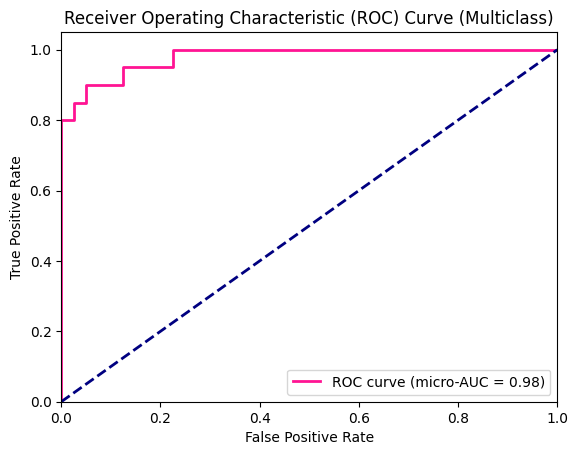

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Example ground truth and predicted probabilities for multiclass
# Replace these arrays with your actual ground truth and predicted probabilities
y_score = y_score.detach().cpu().numpy() 
y_true = y_true.detach().cpu().numpy()

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()

# ****ROC-AUC for Test data ******

In [47]:
test_path='/kaggle/input/png-lensing/png_dataset/test'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [48]:
for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        y_score=model(images)
        y_true=labels

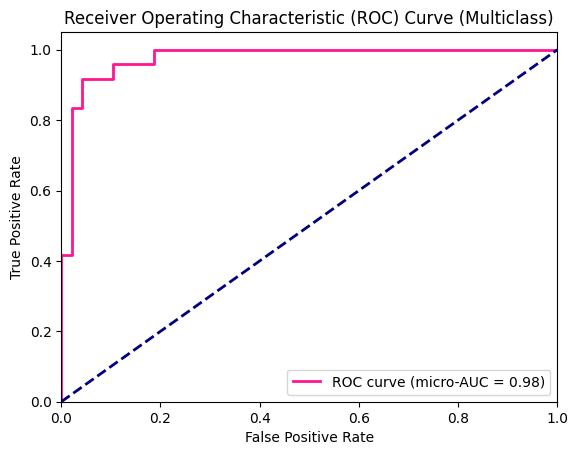

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Example ground truth and predicted probabilities for multiclass
# Replace these arrays with your actual ground truth and predicted probabilities
y_score = y_score.detach().cpu().numpy() 
y_true = y_true.detach().cpu().numpy()

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and ROC area for each class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label=f'ROC curve (micro-AUC = {roc_auc["micro"]:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()